For modeling/classification purposes, we will focus on the subset of the data that includes closed and acquired companies, excluding companies that are currently operating.

In [ ]:
data_ac = df[df['status'] != 'operating']

In [ ]:
# checking for nulls
data_ac.isnull().sum()

name                       2
market                   611
funding_total_usd          1
status                  1315
country_code             835
state_code              2582
region                   835
city                     951
funding_rounds             1
founded_at              1720
founded_month           1725
founded_year            1725
first_funding_at           1
last_funding_at            1
seed                       1
venture                    1
equity_crowdfunding        1
undisclosed                1
convertible_note           1
debt_financing             1
angel                      1
grant                      1
private_equity             1
product_crowdfunding       1
round_A                    1
round_B                    1
round_C                    1
round_D                    1
round_E                    1
round_F                    1
round_G                    1
round_H                    1
dtype: int64

In [ ]:
len(data_ac)

7610

In [ ]:
data_ac = data_ac.dropna(subset=['status', 'name'])
len(data_ac)

6294

In [ ]:
data_ac.dtypes

name                     object
market                   object
funding_total_usd        object
status                   object
country_code             object
state_code               object
region                   object
city                     object
funding_rounds          float64
founded_at               object
founded_month            object
founded_year            float64
first_funding_at         object
last_funding_at          object
seed                    float64
venture                 float64
equity_crowdfunding     float64
undisclosed             float64
convertible_note        float64
debt_financing          float64
angel                   float64
grant                   float64
private_equity          float64
product_crowdfunding    float64
round_A                 float64
round_B                 float64
round_C                 float64
round_D                 float64
round_E                 float64
round_F                 float64
round_G                 float64
round_H 

In [ ]:
# converting to float
data_ac['funding_total_usd'] = [float(num) for num in data_ac['funding_total_usd']]

In [ ]:
data_ac['status'].value_counts(normalize=True)

acquired    0.58659
closed      0.41341
Name: status, dtype: float64

In [ ]:
# filling categoricals
data_ac = data_ac.fillna(value={'market': 'other', 'country_code': 'other', 
                                'region': 'other', 'city': 'other', 
                                'state_code': 'other'})

1st percentile of founded_year:  1982.0
Num Rows before 1980:  35


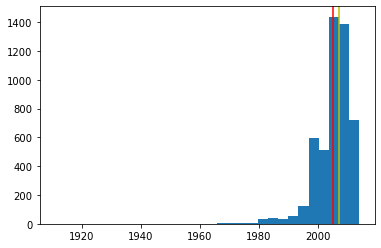

In [ ]:
# distribution of non NA years 
plt.hist(data_ac['founded_year'][~data_ac['founded_year'].isnull()], bins=30)
plt.axvline(x=np.nanmean(data_ac['founded_year']), color='r')
plt.axvline(x=np.nanmedian(data_ac['founded_year']), color='y')

p1 = np.percentile(data_ac['founded_year'][~data_ac['founded_year'].isnull()], 1)
print("1st percentile of founded_year: ", p1)

#1980 looks like a good cutoff point
print("Num Rows before 1980: ", len(data_ac[data_ac['founded_year'] < 1980]))
data_ac = data_ac[data_ac['founded_year'] >= 1980].reset_index(drop=True)

In [ ]:
data_ac['founded_at'] = [datetime.strptime(day, '%Y-%m-%d') for day \
                         in data_ac['founded_at'][~data_ac['founded_at'].isnull()]]
data_ac['first_funding_at'] = [datetime.strptime(day, '%Y-%m-%d').date() for day \
                               in data_ac['first_funding_at']]
data_ac['last_funding_at'] = [datetime.strptime(day, '%Y-%m-%d').date() for day \
                              in data_ac['last_funding_at']]
data_ac['founded_month'] = [datetime.strptime(mth, "%Y-%m").month for mth in data_ac['founded_month']]

In [ ]:
# imputing median for day, then pulling founded year and month from that
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

data_ac['founded_at'] = imp_median.fit_transform(data_ac[['founded_at']])

data_ac['founded_at'] = pd.to_datetime(data_ac['founded_at'])
data_ac['founded_year'] = [day.year for day in data_ac['founded_at']]
data_ac['founded_month'] = [day.month for day in data_ac['founded_at']]

In [ ]:
# creating column that labels country as domestic or international
data_ac['international'] = [0 if country=='USA' else 1 for country in data_ac['country_code']]

In [ ]:
# creating temporary columns to aid in calcuation of time to first funding

data_ac['founded_at_temp'] = [day.date() for day in data_ac['founded_at']]
data_ac['founded_at_temp'] = pd.to_datetime(data_ac['founded_at_temp'], 
                                            format = '%Y-%m-%d')

data_ac['first_funding_at_temp'] = pd.to_datetime(data_ac['first_funding_at'], 
                                                  format = '%Y-%m-%d', 
                                                  errors='coerce')
data_ac['last_funding_at_temp'] = pd.to_datetime(data_ac['last_funding_at'], 
                                                 format = '%Y-%m-%d', 
                                                 errors='coerce')

data_ac['time_to_first_funding'] = (data_ac['first_funding_at_temp'] - \
                                    data_ac['founded_at_temp']) / pd.Timedelta(days=365)

data_ac['time_first_to_last_funding'] = (data_ac['last_funding_at_temp'] - \
                                         data_ac['first_funding_at_temp']) / pd.Timedelta(days=365)

In [ ]:
# checking for nulls
print(data_ac['first_funding_at'][data_ac['time_to_first_funding'].isnull()])
print(data_ac['last_funding_at'][data_ac['time_first_to_last_funding'].isnull()])

3697    0011-11-14
Name: first_funding_at, dtype: object
3697    2012-07-24
Name: last_funding_at, dtype: object


In [ ]:
data_ac = data_ac.dropna(subset=['time_to_first_funding']).reset_index(drop=True)

In [ ]:
# getting rid of extra spaces

data_ac['market'] = [x.strip() for x in data_ac['market']]
data_ac['country_code'] = [x.strip() for x in data_ac['country_code']]
data_ac['state_code'] = [x.strip() for x in data_ac['state_code']]
data_ac['region'] = [x.strip() for x in data_ac['region']]
data_ac['city'] = [x.strip() for x in data_ac['city']]

Text(0.5, 1.0, 'Heatmap of Correlation Between Attributes (Including Status)')

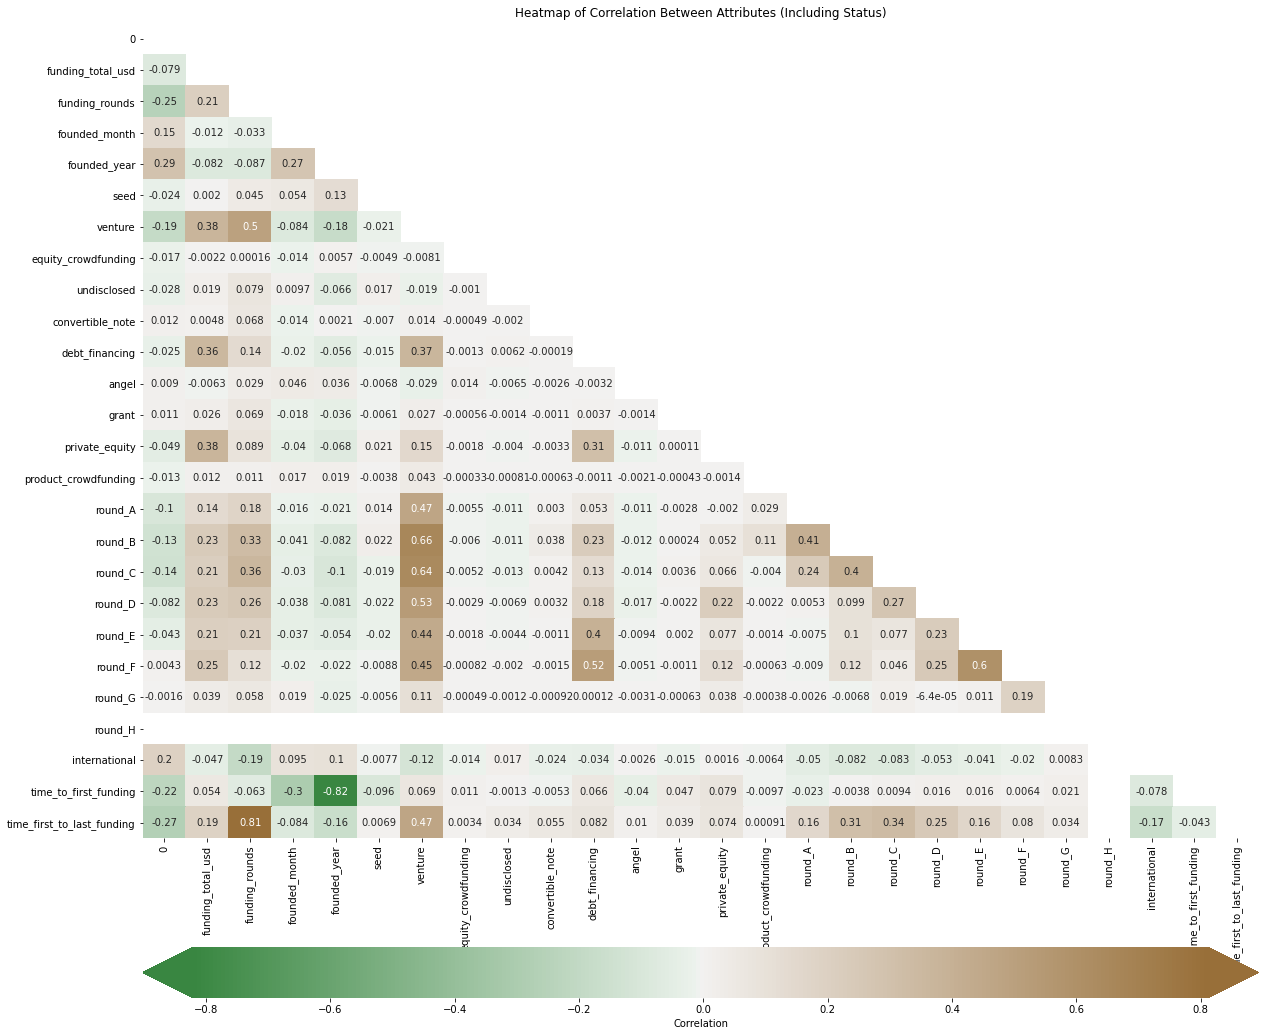

In [ ]:
# correlation check
# with status
encoder = LabelEncoder()
heatmap_data = pd.concat([pd.Series(encoder.fit_transform(data_ac['status'])), 
                          data_ac.drop('status', axis=1)], axis=1)

# without status
#heatmap_data = data.drop('status', axis=1)

h_corr = heatmap_data.corr()
fig, ax = plt.subplots(figsize=(20, 20))
mask = np.triu(np.ones_like(h_corr, dtype=bool))
cmap = sns.diverging_palette(130, 50, as_cmap=True)
cbar_kws = {'label': 'Correlation', 'orientation': 'horizontal', 
            'pad': .1, 'extend': 'both'}
sns.heatmap(data=h_corr, mask=mask, ax=ax, annot=True, cbar_kws=cbar_kws, cmap=cmap)
ax.set_title('Heatmap of Correlation Between Attributes (Including Status)')

In [ ]:
corr = h_corr.abs().stack().reset_index().sort_values(0, ascending=False)
corr['pairs'] = list(zip(corr.level_0, corr.level_1))
corr.set_index(['pairs'], inplace = True)
corr.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
corr.columns = ['cc']
corr.drop_duplicates(inplace=True)

corr[(corr['cc'] > 0.7) & (corr['cc'] < 1)]

,cc
pairs,
"(time_to_first_funding, founded_year)",0.819908
"(funding_rounds, time_first_to_last_funding)",0.812019


In [ ]:
# reducing number of categories in market & region

print(sum(data_ac['market'].value_counts() >= 15)) # top ~50 markets
data_ac['market'][data_ac['market'].map(data_ac['market'].value_counts()) < 15] = 'other'
print(data_ac['market'].value_counts())

print(sum(data_ac['region'].value_counts() >= 60)) # top 10-15 regions
data_ac['region'][data_ac['region'].map(data_ac['region'].value_counts()) < 60] = 'other'
print(data_ac['region'].value_counts())

48
other                    1162
Software                  569
Curated Web               347
Mobile                    281
Enterprise Software       200
Biotechnology             189
Advertising               173
Games                     172
E-Commerce                164
Social Media              136
Hardware + Software       100
Semiconductors             96
Security                   92
Web Hosting                84
Clean Technology           78
Health Care                75
Finance                    71
Analytics                  59
Messaging                  55
Search                     54
News                       47
Music                      45
Education                  43
Public Relations           42
Video                      41
Travel                     40
Networking                 38
Photography                36
Social Network Media       34
Consulting                 33
Health and Wellness        32
SaaS                       29
Sports                     25
Web Dev

In [ ]:
#data_ac['region'].value_counts()[data_ac['region'].value_counts() > 75]

In [ ]:
# dropping correlated columns for logistic regression, which can be
# sensitive to correlated features
data_final = data_ac.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 
                                   'first_funding_at_temp', 'last_funding_at_temp', 
                                   'founded_at_temp', 'round_H', 'founded_year',  
                                   'time_first_to_last_funding'], 
                       axis=1)
# all inclusive
data_final2 = data_ac.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 
                                    'first_funding_at_temp', 'last_funding_at_temp', 
                                    'founded_at_temp', 'round_H'], 
                       axis=1)

In [ ]:
data_final.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_month',
       'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
       'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'international',
       'time_to_first_funding'],
      dtype='object')

In [ ]:
data_final2.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_month',
       'founded_year', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
       'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'international',
       'time_to_first_funding', 'time_first_to_last_funding'],
      dtype='object')